## pipeline

In [5]:
import numpy as np
import os
import pickle
import copy
import edt
import matplotlib.pyplot as plt
import time
import cv2
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from skimage.metrics import adapted_rand_error

import torch
from torch import from_numpy as from_numpy
from torchsummary import summary

from func.run_pipeline_super_vox import segment_super_vox_3_channel_edge_gated_model, semantic_segment_crop_and_cat_3_channel_output_edge_gated_model, img_3d_erosion_or_expansion, \
generate_super_vox_by_watershed, get_outlayer_of_a_3d_shape, get_crop_by_pixel_val, Cluster_Super_Vox, assign_boudary_voxels_to_cells_with_watershed, \
delete_too_small_cluster, reassign
from func.run_pipeline import segment, assign_boudary_voxels_to_cells, dbscan_of_seg, semantic_segment_crop_and_cat
from func.cal_accuracy import IOU_and_Dice_Accuracy, VOI
from func.network import VoxResNet, CellSegNet_basic_lite, CellSegNet_basic_lite_w_groupnorm_deep_supervised
from func.unet_3d_basic import UNet3D_basic
from func.ultis import save_obj, load_obj

### init model

In [6]:
# model=UNet3D_basic(in_channels = 1, out_channels = 3)
# load_path=''
# model=VoxResNet(input_channel=1, n_classes=3, output_func = "softmax")
# load_path=""

model=CellSegNet_basic_lite_w_groupnorm_deep_supervised(input_channel=1, n_classes=3, output_func = "softmax")
load_path='output/model_HMS_w_groupnorm_batchsize7_deep_supervision.pkl'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])
#model.load_state_dict(checkpoint)

model.eval()
"""
for child in model.children():
    print(child)
    if type(child).__name__.startswith('BatchNorm'):
        child.track_running_stats = False
"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#summary(model, (1, 64, 64, 64))

CellSegNet_basic_lite_w_groupnorm_deep_supervised(
  (conv1): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bnorm1): GroupNorm(1, 32, eps=1e-05, affine=True)
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule1): ResModule_w_groupnorm(
    (groupnorm_module): GroupNorm(1, 64, eps=1e-05, affine=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule2): ResModule_w_groupnorm(
    (groupnorm_module): GroupNorm(1, 64, eps=1e-05, affine=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule3): ResModule_w_groupnorm(
    (groupnorm_module): GroupNorm(1, 64, ep

### dataset info

In [7]:
HMS_data_dict = load_obj("dataset_info/HMS_dataset_info")
HMS_data_dict_test = HMS_data_dict["test"]

### seg one img

parameter setting

In [8]:
# we do not input the whole raw image to the model one time but input raw image crops
crop_cube_size=64
stride=32

# hyperparameter for TASCAN, min touching area of two super pixels if they belong to the same cell
min_touching_area=30

choose a test image and load it

In [9]:
print("Test cases: "+str(HMS_data_dict_test.keys()))
case = "135"
print("for test case "+str(case)+" : "+str(HMS_data_dict_test[case]))

# you may load the image using another path
raw_img=np.load(HMS_data_dict_test[case]["raw"]).astype(float)
hand_seg=np.load(HMS_data_dict_test[case]["ins"]).astype(float)

Test cases: dict_keys(['135', '120', '65', '90'])
for test case 135 : {'raw': 'data/CellSeg_dataset/HMS_processed/raw/135.npy', 'background': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_background_3d_mask.npy', 'boundary': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_boundary_3d_mask.npy', 'foreground': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_foreground_3d_mask.npy', 'ins': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_ins.npy'}


raw_img.shape
raw_img = raw_img[:, 50:, :]
hand_seg = hand_seg[:, 50:, :]

In [10]:
# get gt boundary

boundary_gt = np.load(HMS_data_dict_test[case]["boundary"]).astype(float)

feed raw image crops to the model

In [11]:
start = time.time()

# feed the raw img to the model
print('Feed raw img to model')
raw_img_size=raw_img.shape
    
seg_background_comp = np.zeros(raw_img_size)
seg_boundary_comp = np.zeros(raw_img_size)

transposes = [[0,1,2]]#,[2,0,1],[0,2,1]]
reverse_transposes = [[0,1,2]]#,[1,2,0],[0,2,1]]

for idx, transpose in enumerate(transposes):
    print(str(idx+1)+": Transpose the image to be: "+str(transpose))
    with torch.no_grad():
        seg_img =\
        semantic_segment_crop_and_cat_3_channel_output_edge_gated_model(raw_img.transpose(transpose), model, device, crop_cube_size=crop_cube_size, stride=stride)
    seg_img_background=seg_img['background']
    seg_img_boundary=seg_img['boundary']
    seg_img_foreground=seg_img['foreground']
    torch.cuda.empty_cache()
    
    # argmax
    print('argmax', end='\r')
    seg=[]
    seg.append(seg_img_background)
    seg.append(seg_img_boundary)
    seg.append(seg_img_foreground)
    seg=np.array(seg)
    seg_argmax=np.argmax(seg, axis=0)
    # probability map to 0 1 segment
    seg_background=np.zeros(seg_img_background.shape)
    seg_background[np.where(seg_argmax==0)]=1
    seg_foreground=np.zeros(seg_img_foreground.shape)
    seg_foreground[np.where(seg_argmax==2)]=1
    seg_boundary=np.zeros(seg_img_boundary.shape)
    seg_boundary[np.where(seg_argmax==1)]=1
        
    seg_background=seg_background.transpose(reverse_transposes[idx])
    seg_foreground=seg_foreground.transpose(reverse_transposes[idx])
    seg_boundary=seg_boundary.transpose(reverse_transposes[idx])
        
    seg_background_comp+=seg_background
    seg_boundary_comp+=seg_boundary
#print("Get model semantic seg by combination")
seg_background_comp = np.array(seg_background_comp>0, dtype=float)
seg_boundary_comp = np.array(seg_boundary_comp>0, dtype=float)
seg_foreground_comp = np.array(1 - seg_background_comp - seg_boundary_comp>0, dtype=float)

end = time.time()

print("Time elapsed: ", end - start)

Feed raw img to model
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Time elapsed:  285.0284171104431


4

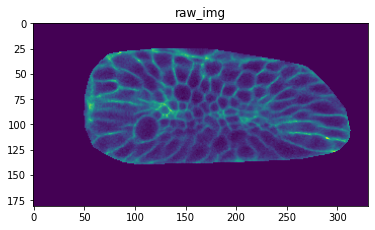

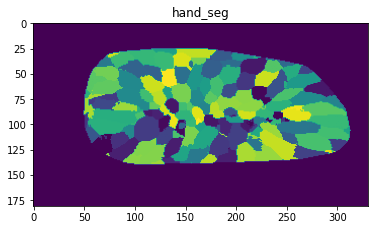

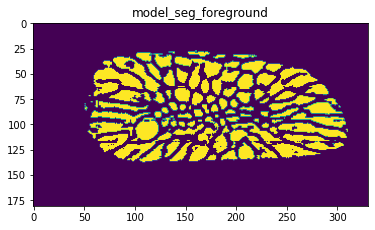

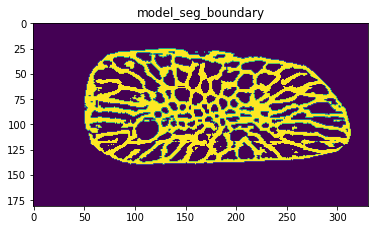

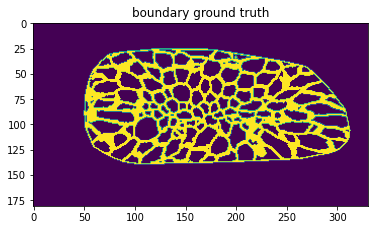

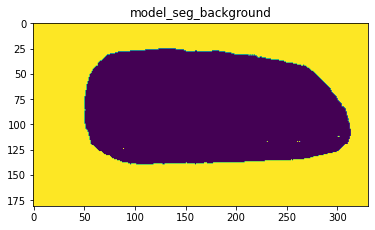

In [12]:
# show current result

N=100

plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[:,:,N])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[:,:,N]))
plt.figure()
plt.title("model_seg_foreground")
plt.imshow(seg_foreground_comp[:,:,N])
plt.figure()
plt.title("model_seg_boundary")
plt.imshow(seg_boundary_comp[:,:,N])
plt.figure()
plt.title("boundary ground truth")
plt.imshow(boundary_gt[:,:,N])
plt.figure()
plt.title("model_seg_background")
plt.imshow(seg_background_comp[:,:,N])

TASCAN

generate super vox by watershed

In [13]:
how_close_are_the_super_vox_to_boundary=2
min_touching_percentage=0.51

seg_foreground_erosion=1-img_3d_erosion_or_expansion(1-seg_foreground_comp, kernel_size=how_close_are_the_super_vox_to_boundary+1, device=device)
seg_foreground_super_voxel_by_ws = generate_super_vox_by_watershed(seg_foreground_erosion, connectivity=min_touching_area)

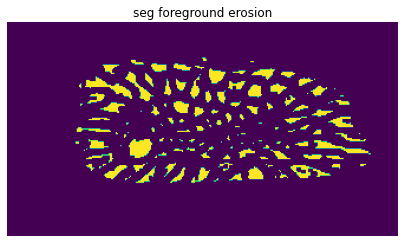

In [14]:
fig = plt.figure(figsize=(7,7))
plt.title("seg foreground erosion")
plt.axis('off')
plt.imshow(seg_foreground_erosion[:,:,N])

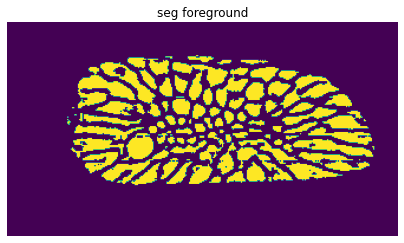

In [15]:
fig = plt.figure(figsize=(7,7))
plt.title("seg foreground")
plt.axis('off')
plt.imshow(seg_foreground_comp[:,:,N])

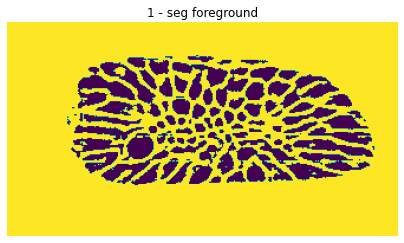

In [16]:
fig = plt.figure(figsize=(7,7))
plt.title("1 - seg foreground")
plt.axis('off')
plt.imshow(1-seg_foreground_comp[:,:,N])

In [17]:
print("There are "+str(len(np.unique(seg_foreground_super_voxel_by_ws)))+" super voxels")

There are 3100 super voxels


super voxel clustearing

In [18]:
cluster_super_vox=Cluster_Super_Vox(min_touching_area=min_touching_area, min_touching_percentage=min_touching_percentage)
cluster_super_vox.fit(seg_foreground_super_voxel_by_ws)
seg_foreground_single_cell_with_boundary = cluster_super_vox.output_3d_img

025]1762 1825]1909 1994]current_crop_outlayer_area: 231current_crop_outlayer_area: 230current_crop_outlayer_area: 15current_crop_outlayer_area: 24current_crop_outlayer_area: 47current_crop_outlayer_area: 102current_crop_outlayer_area: 47current_crop_outlayer_area: 2current_crop_outlayer_area: 79current_crop_outlayer_area: 56current_crop_outlayer_area: 37current_crop_outlayer_area: 31current_crop_outlayer_area: 27current_crop_outlayer_area: 4current_crop_outlayer_area: 18current_crop_outlayer_area: 74current_crop_outlayer_area: 23current_crop_outlayer_area: 70current_crop_outlayer_area: 36current_crop_outlayer_area: 31current_crop_outlayer_area: 5current_crop_outlayer_area: 92current_crop_outlayer_area: 21current_crop_outlayer_area: 14current_crop_outlayer_area: 30current_crop_outlayer_area: 78current_crop_outlayer_area: 31current_crop_outlayer_area: 79current_crop_outlayer_area: 50current_crop_outlayer_area: 13current_crop_outlayer_area: 62current_crop_outlayer_area: 13current_crop_out

delete too small cells

In [19]:
min_cell_size_threshold=10
seg_foreground_single_cell_with_boundary_delete_too_small = delete_too_small_cluster(seg_foreground_single_cell_with_boundary, threshold=min_cell_size_threshold)

assign boudary voxels to their nearest cells

In [20]:
seg_final=assign_boudary_voxels_to_cells_with_watershed(seg_foreground_single_cell_with_boundary_delete_too_small, seg_boundary_comp, seg_background_comp, compactness=1)

see the final result

In [21]:
def colorful_seg(seg):
    unique_vals, val_counts = np.unique(seg, return_counts=True)
    
    background_val = unique_vals[np.argsort(val_counts)[::-1][0]]
    
    seg_RGB = []
    for i in range(seg.shape[0]):
        mask_gray = cv2.normalize(src=seg[i,:,:], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        seg_slice_RGB = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2RGB)
        seg_RGB.append(seg_slice_RGB)
    seg_RGB = np.array(seg_RGB)
    
    for idx, unique_val in enumerate(unique_vals):
        print(str(idx/len(unique_vals)), end="\r")
        if unique_val == background_val:
            COLOR = np.array([0,0,0], dtype=int)
        else:
            COLOR = np.array(np.random.choice(np.arange(256), size=3, replace=False), dtype=int)
        
        locs = np.where(seg==unique_val)
        
        for i in range(3):
            seg_RGB[locs[0], locs[1], locs[2], i] = COLOR[i]
        
    return seg_RGB

In [22]:
seg_RGB = colorful_seg(seg_final)
hand_seg_RGB = colorful_seg(hand_seg)

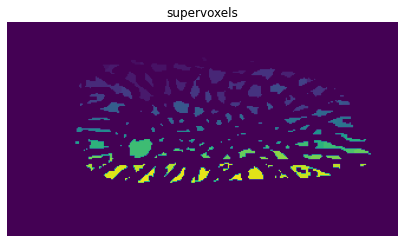

In [23]:
N=100
fig = plt.figure(figsize=(7,7))
plt.title("supervoxels")
plt.axis('off')
plt.imshow(seg_foreground_super_voxel_by_ws[:,:,N])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

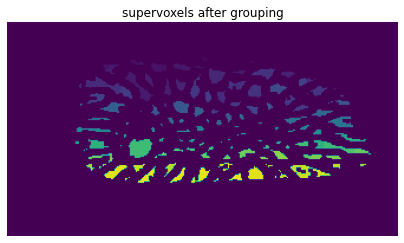

In [24]:
N=100
fig = plt.figure(figsize=(7,7))
plt.title("supervoxels after grouping")
plt.axis('off')
plt.imshow(seg_foreground_single_cell_with_boundary[:,:,N])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

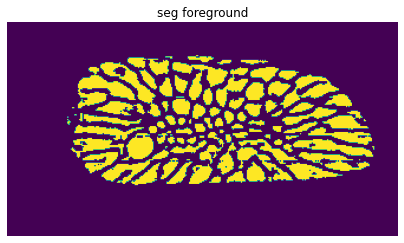

In [25]:
fig = plt.figure(figsize=(7,7))
plt.title("seg foreground")
plt.axis('off')
plt.imshow(seg_foreground_comp[:,:,N])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

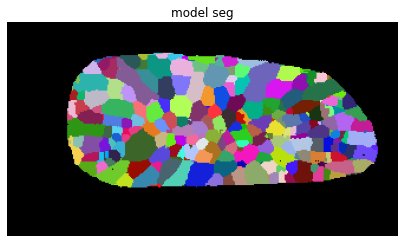

In [26]:
N=100
fig = plt.figure(figsize=(7,7))
plt.title("model seg")
plt.axis('off')
plt.imshow(seg_RGB[:,:,N,:])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

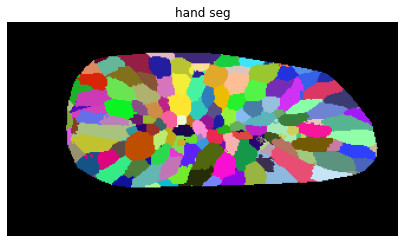

In [27]:
fig = plt.figure(figsize=(7,7))
plt.title("hand seg")
plt.axis('off')
plt.imshow(hand_seg_RGB[:,:,N,:])#,

In [28]:
# print("There are "+str(len(np.unique(seg_final)))+" cells in model prediction")
# print("There are "+str(len(np.unique(hand_seg)))+" cells in hand seg")

calculate accuracy

In [29]:
ARI = adjusted_rand_score(hand_seg.flatten(), seg_final.flatten())
ARE = adapted_rand_error(hand_seg.astype(int).flatten(), seg_final.astype(int).flatten())
VOI_val = VOI(seg_final.astype(int),hand_seg.astype(int))

In [30]:
print("ARI: "+str(ARI))
print("ARE: "+str(ARE))
print("VOI: "+str(VOI_val))

ARI: 0.9807895727272751
ARE: (0.4528618358348697, 0.5132987230539806, 0.5857542685627842)
VOI: (2.0389965931804284, 1.058515457038448)


In [31]:
def img_3d_interpolate(img_3d, output_size, device = torch.device('cpu'), mode='nearest'):
    img_3d = img_3d.reshape(1,1,img_3d.shape[0],img_3d.shape[1],img_3d.shape[2])
    img_3d=torch.from_numpy(img_3d).float().to(device)
    img_3d=torch.nn.functional.interpolate(img_3d, size=output_size, mode='nearest')
    img_3d=img_3d.detach().cpu().numpy()
    img_3d=img_3d.reshape(img_3d.shape[2],img_3d.shape[3],img_3d.shape[4])
    
    return img_3d

scale_factor = 0.5
org_shape = seg_final.shape
output_size = (int(org_shape[0]*scale_factor), int(org_shape[1]*scale_factor), int(org_shape[2]*scale_factor))
print(str(org_shape)+" --> "+str(output_size))

(181, 331, 160) --> (90, 165, 80)


In [32]:
accuracy=IOU_and_Dice_Accuracy(img_3d_interpolate(hand_seg, output_size = output_size), img_3d_interpolate(seg_final, output_size = output_size))
accuracy_record=accuracy.cal_accuracy_II()

iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

print('avg iou: '+str(np.mean(accuracy_record[:,1])))
print('avg dice: '+str(np.mean(accuracy_record[:,2])))

rogress: 8.77659574468085%progress: 9.574468085106384%progress: 10.106382978723403%progress: 10.638297872340425%progress: 11.170212765957446%progress: 11.96808510638298%progress: 12.5%progress: 13.297872340425531%progress: 13.829787234042554%progress: 14.893617021276595%progress: 15.425531914893616%progress: 15.957446808510639%progress: 16.48936170212766%progress: 17.02127659574468%progress: 17.819148936170212%progress: 18.617021276595743%progress: 19.414893617021274%progress: 20.212765957446805%progress: 20.74468085106383%progress: 21.27659574468085%progress: 21.808510638297875%progress: 22.340425531914892%progress: 23.670212765957448%progress: 24.73404255319149%progress: 26.063829787234045%progress: 26.861702127659576%progress: 27.393617021276594%progress: 28.45744680851064%progress: 28.98936170212766%progress: 29.78723404255319%progress: 30.585106382978722%progress: 31.382978723404253%progress: 32.4468085106383%progress: 32.97872340425532%progress: 33.77659574468085%progress: 34.574

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/259725777.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/259725777.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

### seg all imgs

In [33]:
def img_3d_interpolate(img_3d, output_size, device = torch.device('cpu'), mode='nearest'):
    img_3d = img_3d.reshape(1,1,img_3d.shape[0],img_3d.shape[1],img_3d.shape[2])
    img_3d=torch.from_numpy(img_3d).float().to(device)
    img_3d=torch.nn.functional.interpolate(img_3d, size=output_size, mode='nearest')
    img_3d=img_3d.detach().cpu().numpy()
    img_3d=img_3d.reshape(img_3d.shape[2],img_3d.shape[3],img_3d.shape[4])
    
    return img_3d

def pipeline(raw_img, hand_seg, model, device,
             crop_cube_size, stride,
             how_close_are_the_super_vox_to_boundary=2,
             min_touching_area=30,
             min_touching_percentage=0.51,
             min_cell_size_threshold=1,
             transposes = [[0,1,2]], reverse_transposes = [[0,1,2]]):
    
    seg_final=segment_super_vox_3_channel_edge_gated_model(raw_img, model, device,
                                                          crop_cube_size=crop_cube_size, stride=stride,
                                                          how_close_are_the_super_vox_to_boundary=how_close_are_the_super_vox_to_boundary,
                                                          min_touching_area=min_touching_area,
                                                          min_touching_percentage=min_touching_percentage,
                                                          min_cell_size_threshold=min_cell_size_threshold,
                                                          transposes = transposes, reverse_transposes = reverse_transposes)
    
    ari = adjusted_rand_score(hand_seg.flatten(), seg_final.flatten())
    voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))
    
    scale_factor = 0.5
    org_shape = seg_final.shape
    output_size = (int(org_shape[0]*scale_factor), int(org_shape[1]*scale_factor), int(org_shape[2]*scale_factor))
    print(str(org_shape)+" --> "+str(output_size))
    
    accuracy=IOU_and_Dice_Accuracy(img_3d_interpolate(hand_seg, output_size = output_size),
                                   img_3d_interpolate(seg_final, output_size = output_size))
    accuracy_record=accuracy.cal_accuracy_II()
    hand_seg_after_accuracy=accuracy.gt
    seg_final_after_accuracy=accuracy.pred
    
    return accuracy_record, hand_seg_after_accuracy, seg_final_after_accuracy, ari, voi, seg_final

In [34]:
# mass process
seg_final_dict={}
accuracy_record_dict = {}
ari_dict = {}
voi_dict = {}
for test_file in HMS_data_dict_test.keys():
    print(test_file)
    raw_img=np.load(HMS_data_dict_test[test_file]["raw"])
    hand_seg=np.load(HMS_data_dict_test[test_file]["ins"])
    accuracy_record, hand_seg_after_accuracy, seg_final_after_accuracy, ari, voi, seg_final=\
    pipeline(raw_img, hand_seg, model, device,
             crop_cube_size=64,
             stride=32)
    
    seg_final_dict[test_file] = seg_final
    accuracy_record_dict[test_file] = accuracy_record
    ari_dict[test_file] = ari
    voi_dict[test_file] = voi
    
    iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
    print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
    print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
    iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
    print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
    print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

    print('avg iou: '+str(np.mean(accuracy_record[:,1])))
    print('avg dice: '+str(np.mean(accuracy_record[:,2])))
    print("ari: "+str(ari))
    print("voi: "+str(voi))
    print("----------")

135
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Get model semantic seg by combination
025]1762 1825]1909 1994]current_crop_outlayer_area: 231current_crop_outlayer_area: 230current_crop_outlayer_area: 126current_crop_outlayer_area: 31current_crop_outlayer_area: 5current_crop_outlayer_area: 2current_crop_outlayer_area: 9current_crop_outlayer_area: 0current_crop_outlayer_area: 129current_crop_outlayer_area: 66current_crop_outlayer_area: 18current_crop_outlayer_area: 9current_crop_outlayer_area: 47current_crop_outlayer_area: 0current_crop_outlayer_area: 153current_crop_outlayer_area: 6current_crop_outlayer_area: 59current_crop_outlayer_area: 4current_crop_outlayer_area: 4current_crop_outlayer_area: 11current_crop_outlayer_area: 205current_crop_outlayer_area: 75current_crop_outlayer_area: 35current_crop_outlayer_area: 2current_crop_outlayer_area: 87current_crop_outlayer_area: 20current_crop_outlayer_area: 12current_crop_out

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/1384120445.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
rogress: 4.521276595744681%progress: 5.053191489361701%progress: 6.117021276595745%progress: 6.914893617021277%progress: 7.446808510638298%progress: 7.9787234042553195%progress: 8.51063829787234%progress: 9.308510638297872%progress: 9.840425531914894%progress: 10.638297872340425%progress: 11.170212765957446%progress: 11.96808510638298%progress: 12.76595744680851%progress: 13.297872340425531%progress: 13.829787234042554%progress: 14.627659574468085%progress: 15.159574468085108%progress: 15.691489361702127%progress: 16.48936170212766%progress: 17.287234042553195%progress: 17.819148936170212%progress: 18.351063829787233%progress: 19.148936170212767%progress: 19.680851063829788%progress: 20.212765957446805%progress: 20.74468085106383%progress: 21.27659574468085%progress: 21.808510638297875%progress: 22.340425531914892%progress: 23.138297872340424%progress: 23.670212765957448%progress: 24.20212765957447%progress: 24.73404255319149%progress: 25.5319148936170

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record

cell count accuracy iou >0.7: 0.14361702127659576
cell count accuracy dice >0.7: 0.32978723404255317
cell count accuracy iou >0.5: 0.35904255319148937
cell count accuracy dice >0.5: 0.6143617021276596
avg iou: 0.4167334759766434
avg dice: 0.5498562211844515
ari: 0.9807956110125424
voi: (2.198604748164117, 0.9977916451905371)
----------
120
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Get model semantic seg by combination
634]1520]current_crop_outlayer_area: 6current_crop_outlayer_area: 39current_crop_outlayer_area: 29current_crop_outlayer_area: 121current_crop_outlayer_area: 9current_crop_outlayer_area: 51current_crop_outlayer_area: 2current_crop_outlayer_area: 0current_crop_outlayer_area: 38current_crop_outlayer_area: 9current_crop_outlayer_area: 9current_crop_outlayer_area: 95Assign label 334 to current val's neighbors: [588]current_crop_outlayer_area: 63current_crop_outlayer_area: 27current_crop_outlayer_area: 49curr

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/1384120445.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
cell count accuracy iou >0.7: 0.1910112359550561701123593%progress: 20.786516853932586%progress: 21.34831460674157%progress: 22.191011235955056%progress: 22.752808988764045%progress: 23.876404494382022%progress: 24.43820224719101%progress: 25.280898876404496%progress: 26.12359550561798%progress: 26.685393258426966%progress: 27.247191011235955%progress: 27.808988764044944%progress: 28.370786516853936%progress: 29.213483146067414%progress: 29.775280898876407%progress: 30.337078651685395%progress: 31.179775280898873%progress: 31.741573033707866%progress: 32.58426966292135%progress: 33.42696629213483%progress: 34.26966292134831%progress: 34.831460674157306%progress: 35.674157303370784%progress: 36.235955056179776%progress: 36.79775280898877%progress: 37.359550561797754%progress: 37.92134831460674%progress: 38.48314606741573%progress: 39.04494382022472%progress: 40.168539325842694%progress: 40.73033707865169%progress: 41.57303370786517%progress: 42.69662921

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record

Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Get model semantic seg by combination
36] 2262]2430 2432]tlayer_area: 84current_crop_outlayer_area: 22current_crop_outlayer_area: 26current_crop_outlayer_area: 11current_crop_outlayer_area: 186current_crop_outlayer_area: 102current_crop_outlayer_area: 165current_crop_outlayer_area: 9current_crop_outlayer_area: 0current_crop_outlayer_area: 43current_crop_outlayer_area: 4current_crop_outlayer_area: 105current_crop_outlayer_area: 6current_crop_outlayer_area: 72current_crop_outlayer_area: 37current_crop_outlayer_area: 20current_crop_outlayer_area: 132current_crop_outlayer_area: 47current_crop_outlayer_area: 81current_crop_outlayer_area: 49current_crop_outlayer_area: 82current_crop_outlayer_area: 72current_crop_outlayer_area: 49current_crop_outlayer_area: 89current_crop_outlayer_area: 198current_crop_outlayer_area: 41current_crop_outlayer_area: 2current_crop_outlayer_area: 104curr

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/1384120445.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
cell count accuracy iou >0.7: 0.14473684210526316421052%progress: 7.565789473684211%progress: 8.881578947368421%progress: 9.868421052631579%progress: 10.526315789473683%progress: 11.842105263157894%progress: 12.828947368421053%progress: 14.144736842105262%progress: 15.131578947368421%progress: 16.447368421052634%progress: 17.105263157894736%progress: 19.078947368421055%progress: 20.723684210526315%progress: 21.38157894736842%progress: 22.039473684210524%progress: 22.697368421052634%progress: 23.355263157894736%progress: 24.342105263157894%progress: 25.0%progress: 25.986842105263158%progress: 26.644736842105267%progress: 27.960526315789476%progress: 28.618421052631575%progress: 29.276315789473685%progress: 30.263157894736842%progress: 30.92105263157895%progress: 31.57894736842105%progress: 32.56578947368421%progress: 33.223684210526315%progress: 33.881578947368425%progress: 34.53947368421053%progress: 35.526315789473685%progress: 36.18421052631579%progr

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record

s of segment_3d_img: 99%Get model semantic seg by combination
]33 2190]2207]tlayer_area: 185current_crop_outlayer_area: 158current_crop_outlayer_area: 38current_crop_outlayer_area: 123current_crop_outlayer_area: 149current_crop_outlayer_area: 216current_crop_outlayer_area: 470current_crop_outlayer_area: 81current_crop_outlayer_area: 96current_crop_outlayer_area: 144current_crop_outlayer_area: 0current_crop_outlayer_area: 135current_crop_outlayer_area: 29current_crop_outlayer_area: 18current_crop_outlayer_area: 81current_crop_outlayer_area: 22current_crop_outlayer_area: 6current_crop_outlayer_area: 38current_crop_outlayer_area: 71current_crop_outlayer_area: 27current_crop_outlayer_area: 9current_crop_outlayer_area: 85current_crop_outlayer_area: 98current_crop_outlayer_area: 94current_crop_outlayer_area: 110current_crop_outlayer_area: 43current_crop_outlayer_area: 41current_crop_outlayer_area: 82current_crop_outlayer_area: 30current_crop_outlayer_area: 26current_crop_outlayer_area: 23cur

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/1384120445.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
cell count accuracy iou >0.7: 0.179271708683473433333333%progress: 34.173669467787114%progress: 34.73389355742297%progress: 35.294117647058826%progress: 36.134453781512605%progress: 36.69467787114846%progress: 37.53501400560224%progress: 38.37535014005603%progress: 39.49579831932773%progress: 40.33613445378151%progress: 41.45658263305322%progress: 42.016806722689076%progress: 42.57703081232493%progress: 43.417366946778714%progress: 43.977591036414566%progress: 44.537815126050425%progress: 45.09803921568628%progress: 45.65826330532213%progress: 47.05882352941176%progress: 47.89915966386555%progress: 48.739495798319325%progress: 49.57983193277311%progress: 50.700280112044815%progress: 51.540616246498594%progress: 52.10084033613446%progress: 53.50140056022409%progress: 54.34173669467787%progress: 54.90196078431373%progress: 55.74229691876751%progress: 56.86274509803921%progress: 57.70308123249299%progress: 58.543417366946784%progress: 59.103641456582636%p

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record

In [35]:
for item in seg_final_dict.keys():
    print(item)
    accuracy_record = accuracy_record_dict[item]
    ari = ari_dict[item]
    voi = voi_dict[item]
    iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
    print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
    print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
    iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
    print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
    print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

    print('avg iou: '+str(np.mean(accuracy_record[:,1])))
    print('avg dice: '+str(np.mean(accuracy_record[:,2])))
    print("ari: "+str(ari))
    print("voi: "+str(voi))
    print("----------")




135
cell count accuracy iou >0.7: 0.14361702127659576
cell count accuracy dice >0.7: 0.32978723404255317
cell count accuracy iou >0.5: 0.35904255319148937
cell count accuracy dice >0.5: 0.6143617021276596
avg iou: 0.4167334759766434
avg dice: 0.5498562211844515
ari: 0.9807956110125424
voi: (2.198604748164117, 0.9977916451905371)
----------
120
cell count accuracy iou >0.7: 0.19101123595505617
cell count accuracy dice >0.7: 0.35674157303370785
cell count accuracy iou >0.5: 0.3848314606741573
cell count accuracy dice >0.5: 0.6797752808988764
avg iou: 0.444684234018741
avg dice: 0.577522340241108
ari: 0.9836819836289369
voi: (2.022157876903466, 1.0477645829123352)
----------
65
cell count accuracy iou >0.7: 0.14473684210526316
cell count accuracy dice >0.7: 0.3092105263157895
cell count accuracy iou >0.5: 0.3684210526315789
cell count accuracy dice >0.5: 0.6546052631578947
avg iou: 0.4311095846630786
avg dice: 0.5713812169070527
ari: 0.9818583521459846
voi: (2.246360654904593, 1.021056918

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/583679840.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_46505/583679840.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

In [36]:
# see the difference for supervoxels

how_close_are_the_super_vox_to_boundary=2
min_touching_percentage=0.51

seg_foreground_erosion=1-img_3d_erosion_or_expansion(1-seg_foreground_comp, kernel_size=how_close_are_the_super_vox_to_boundary+1, device=device)
seg_foreground_super_voxel_by_ws = generate_super_vox_by_watershed(seg_foreground_erosion, connectivity=min_touching_area)

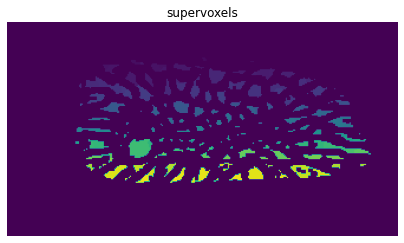

In [37]:
N=100
fig = plt.figure(figsize=(7,7))
plt.title("supervoxels")
plt.axis('off')
plt.imshow(seg_foreground_super_voxel_by_ws[:,:,N])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)
